In [1]:
import sys
sys.path.append('../src')
from main import *
import os 
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Loading images and filenames

In [2]:
sources_filenames, sources_imgs = get_imgs('../data/raw/sources/')
queries_filenames, queries_imgs = get_imgs('../data/raw/queries')

## Template matching function

In [3]:
def template_matching(query_image, source_image, threshold, plot=True, method = cv2.TM_CCOEFF_NORMED):
    
    # Convert to grayscale to speedup
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY).copy()
    source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY).copy()

    # Check if query is smaller than source
    if (query_image.shape[0] > source_image.shape[0]) or (query_image.shape[1] > source_image.shape[1] ):
        return None, 0.
    
    # Perform template matching
    result = cv2.matchTemplate(source_image, query_image, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    # Handling different methods, setting confidence
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        confidence = 1-min_val
        top_left = min_loc # location
    else:
        confidence = max_val
        top_left = max_loc
    
    # Set a threshold for template matching
    if confidence < threshold:
        return None, confidence  # Template not present in the source image
    else:
        return top_left, confidence


def plot_template(query_image, source_image, top_left):
    
    # Get the dimensions of the query image
    query_height, query_width = query_image.shape[:2]

    # Get the coordinates for drawing the rectangle
    bottom_right = (top_left[0] + query_width, top_left[1] + query_height)

    # Draw a rectangle around the matched template
    rect = cv2.rectangle(source_image.copy(), top_left, bottom_right, (0, 255, 0), 2)

    # Plot the source image with the rectangle
    plt.figure()
    plt.imshow(rect)
    plt.axis('off')
    plt.show()


def check_query(query_img):
    
    sources_with_query = []
    ### Stage 1
    for source_img, source_filename in zip(sources_imgs, sources_filenames):
        location, confidence = template_matching(query_img, source_img, threshold=0.95)
        if confidence > 0.95:
            sources_with_query.append((source_filename, location, query_img.shape, confidence))
            plot_template(query_img, source_img, location)
            return sources_with_query
            
            
    ### Stage 2
    if sources_with_query == []:
        for rotate in [cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE]:
            query_img_rt = cv2.rotate(query_img, rotate)
            for source_img, source_filename in zip(sources_imgs, sources_filenames):
                location, confidence = template_matching(query_img_rt, source_img, threshold=0.95)
                if confidence > 0.95:
                    sources_with_query.append((source_filename, location, query_img_rt.shape, confidence))
                    plot_template(query_img_rt, source_img, location)
                    return sources_with_query
                    
    return sources_with_query

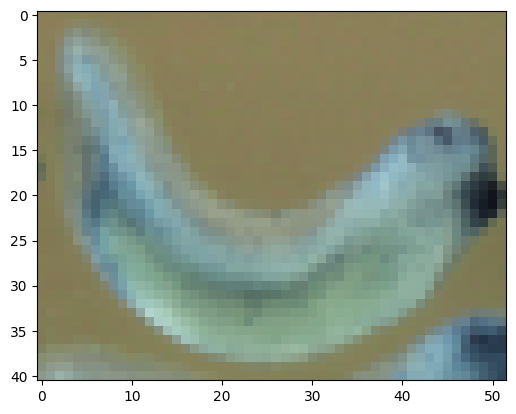

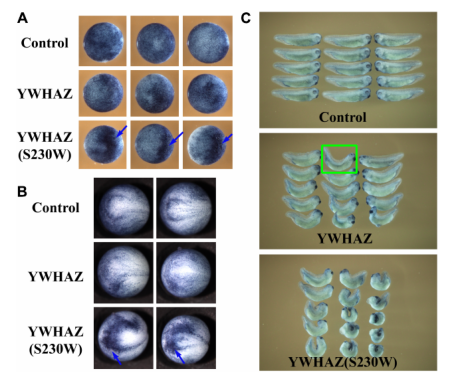

[('../data/raw/sources/90.png', (469, 205), (41, 52, 3), 1.0)]


In [4]:
query=queries_imgs[7]
plt.imshow(query)
sources_with_query = check_query(query)
print(sources_with_query)

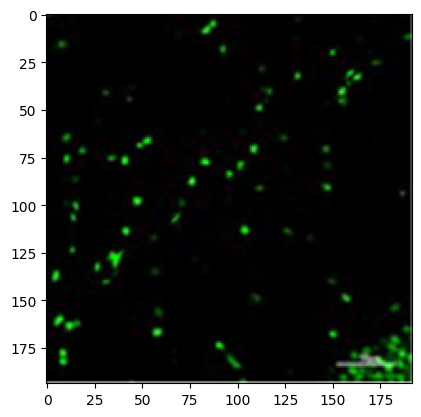

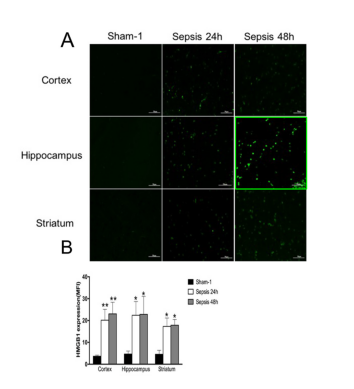

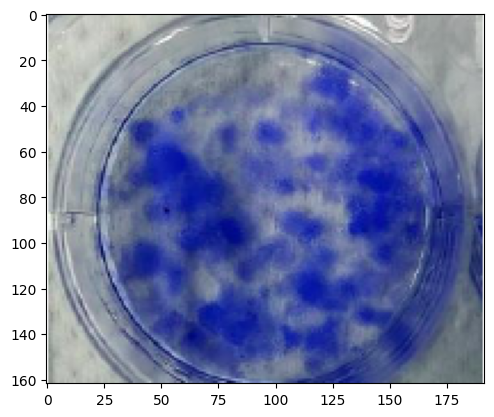

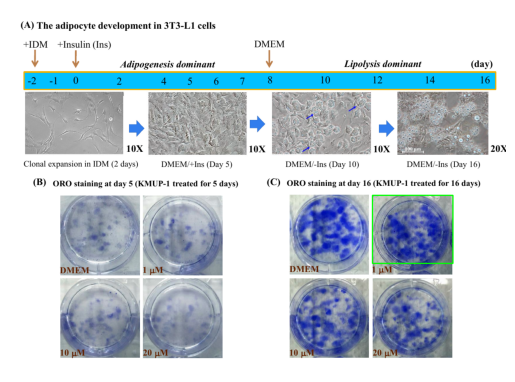

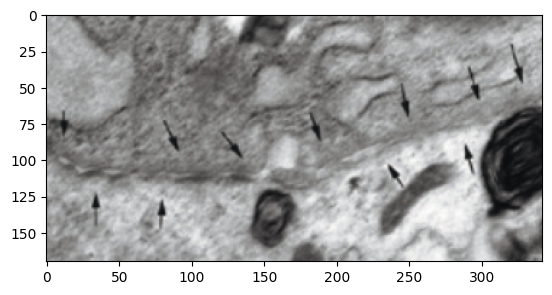

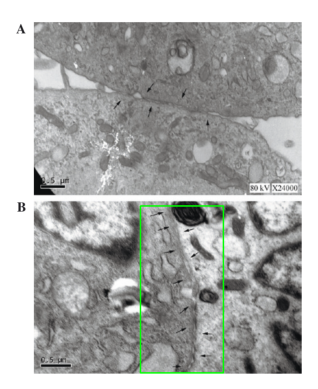

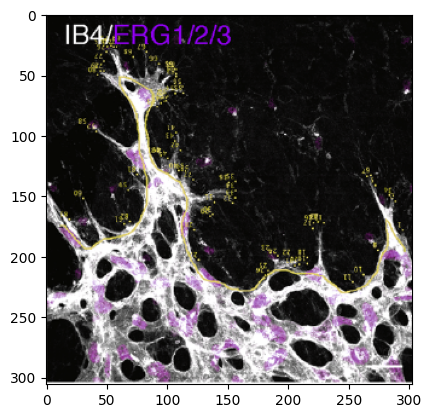

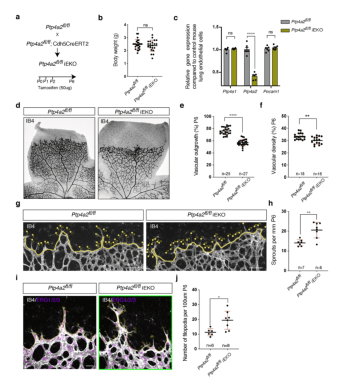

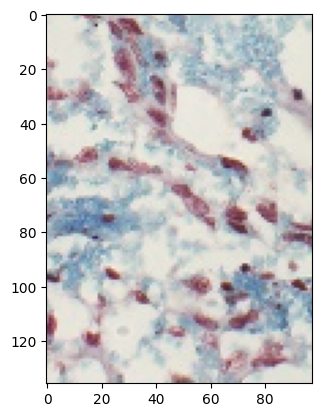

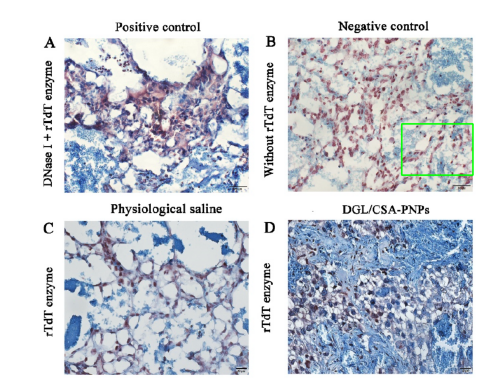

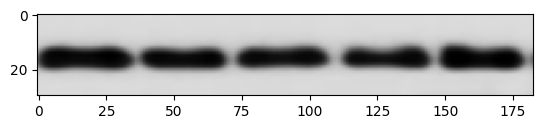

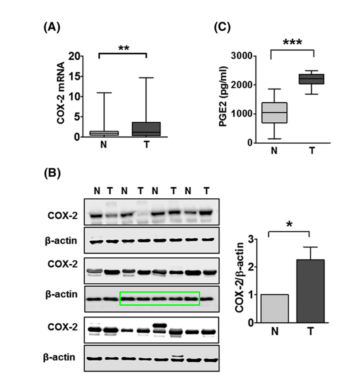

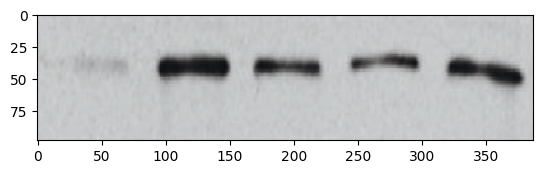

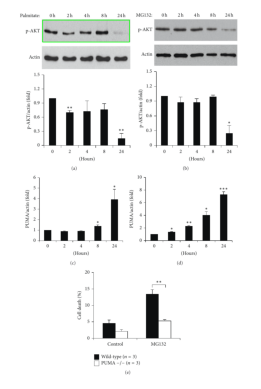

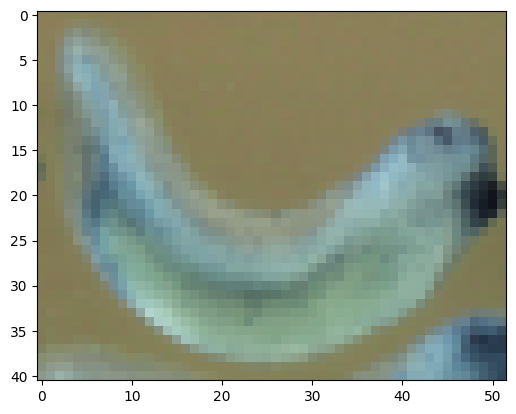

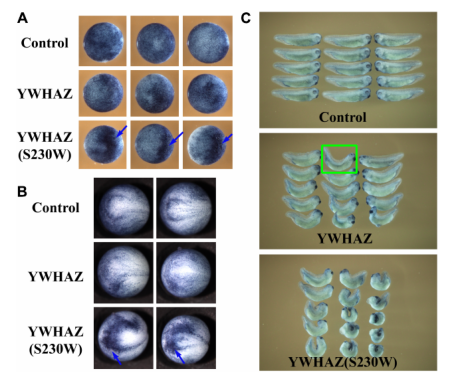

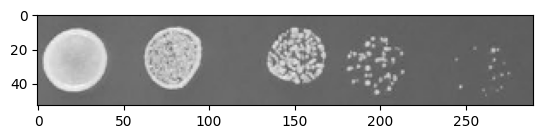

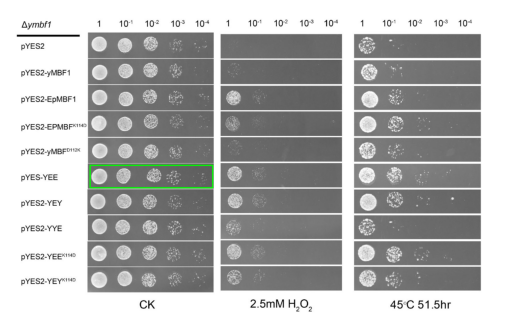

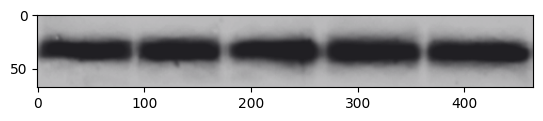

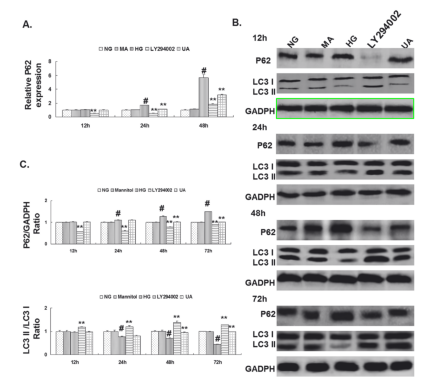

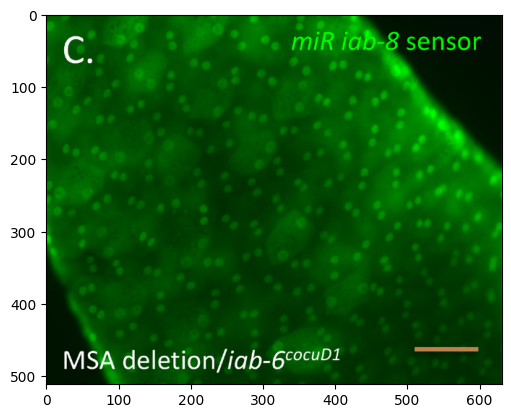

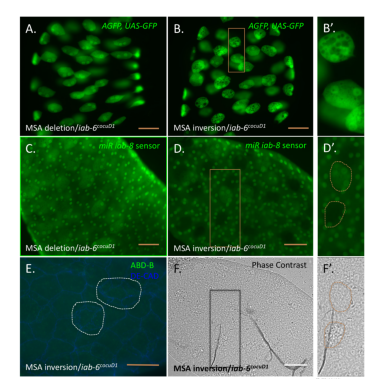

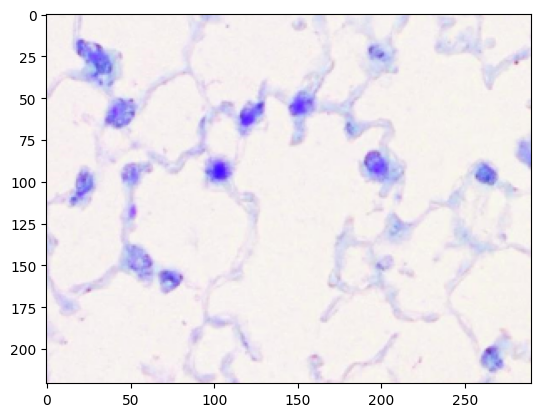

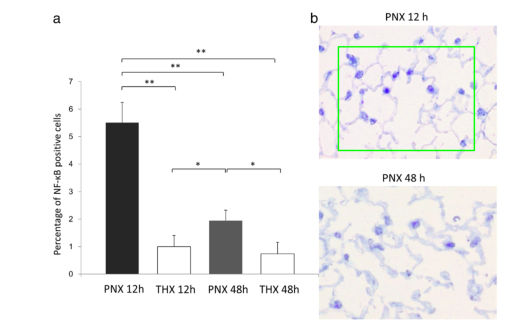

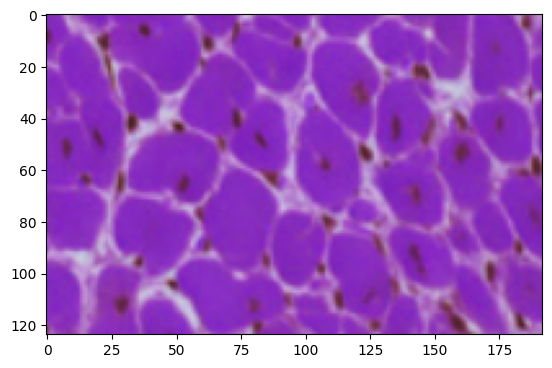

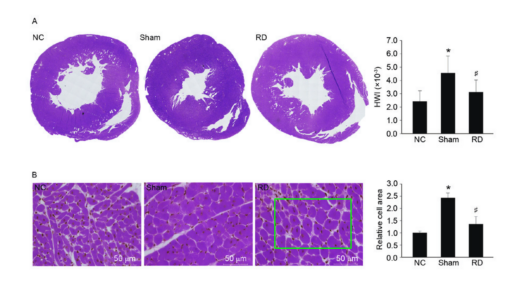

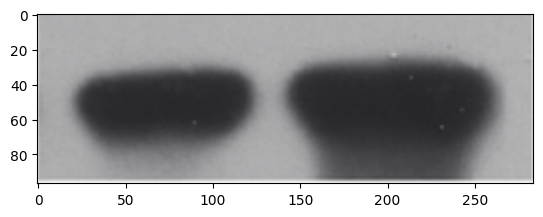

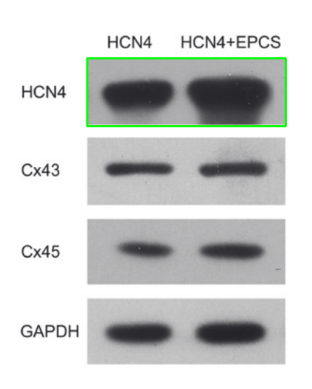

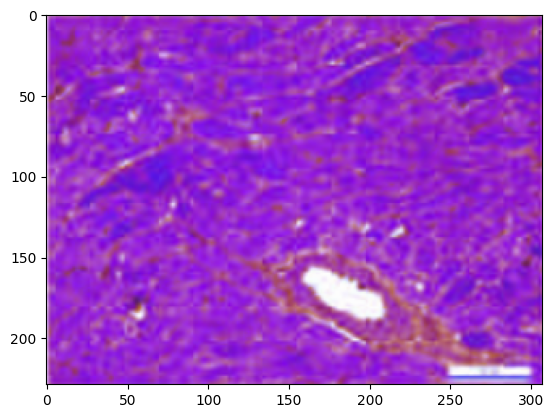

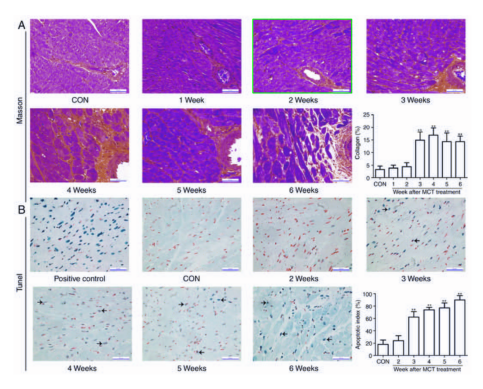

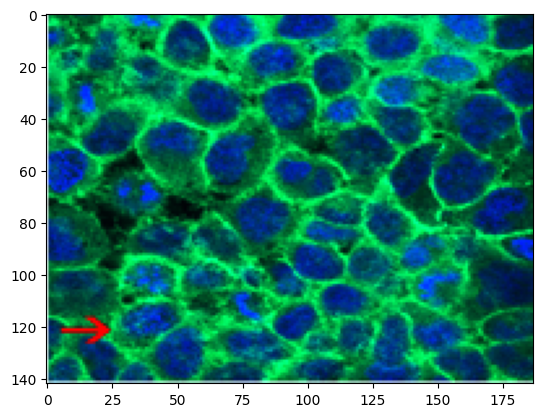

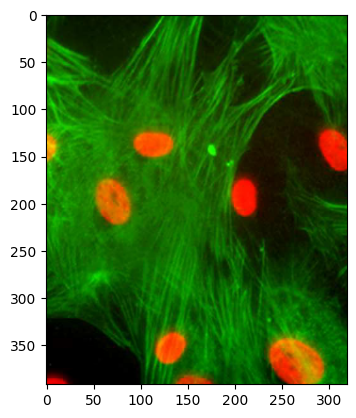

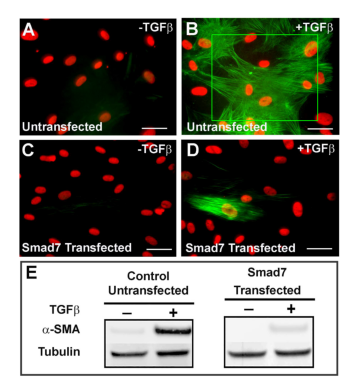

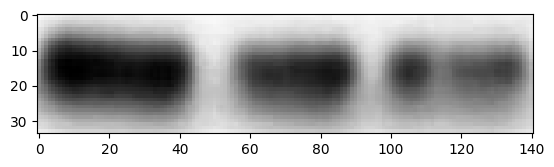

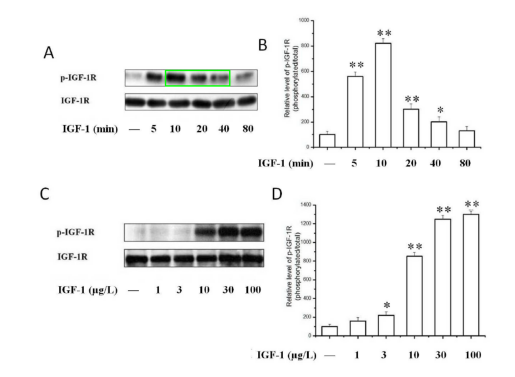

In [5]:
for n, (query_filename, query_img) in enumerate(zip(queries_filenames, queries_imgs)):
    plt.figure()
    plt.imshow(query_img)
    check_query(query_img)

### Handling tricky images

(142, 187, 3)
SSIM score: 0.9096912993856158


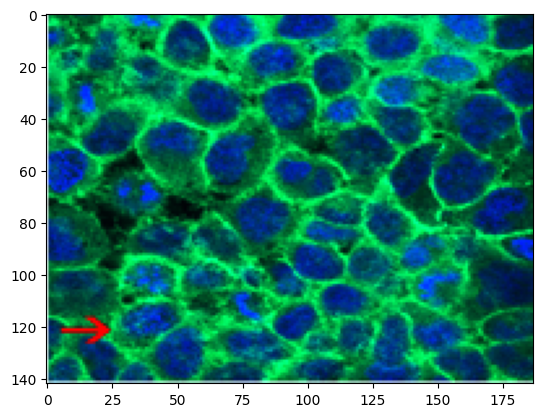

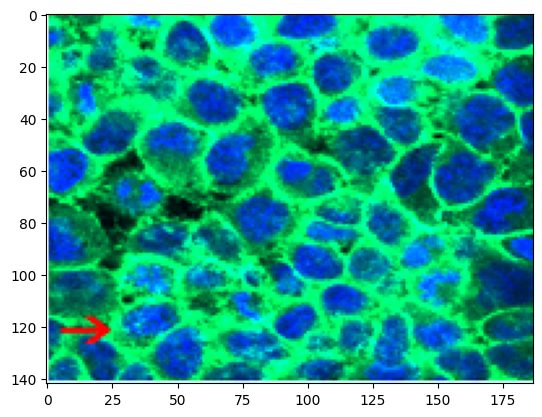

In [7]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Load the original image
original_image = cv2.imread('../data/raw/queries/q1.png')
print(original_image.shape)
plt.imshow(original_image)

# Modify the contrast of the original image
alpha = 1.5  # Contrast control (1.0 for no change)
beta = 30  # Brightness control (0 for no change)
modified_image = cv2.convertScaleAbs(original_image, alpha=1.5)
plt.figure()
plt.imshow(modified_image)

# Calculate the SSIM between the original and modified images
ssim_score = ssim(original_image, modified_image, channel_axis=2)
# Print the SSIM score
print("SSIM score:", ssim_score)


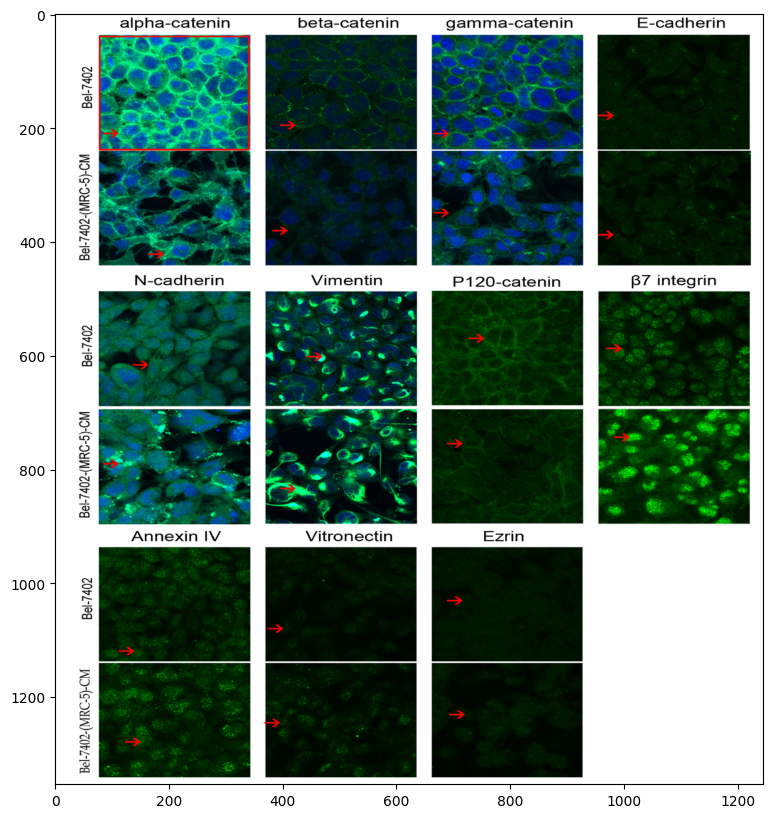

In [8]:
# Load the template and the image
template = cv2.imread("../data/raw/queries/q1.png")
target = cv2.imread("../data/raw/sources/102.png")

# Define the scales to use for the search
scales = np.arange(1,2,0.1)

# Loop over each scale
for scale in scales:
    # Resize the template to the current scale
    template_scaled = cv2.resize(template, None, fx=scale, fy=scale)

    # Perform template matching using the scaled templatec
    result = cv2.matchTemplate(target, template_scaled, cv2.TM_CCOEFF_NORMED)

    # Find the maximum correlation value and its location
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    if max_val > 0.5:
        # Calculate the top-left and bottom-right corners of the bounding box
        top_left = max_loc
        bottom_right = (top_left[0] + template_scaled.shape[1], top_left[1] + template_scaled.shape[0])

        # Draw a rectangle around the matched region
        rect = cv2.rectangle(target.copy(), top_left, bottom_right, 255, 2)

# Display the result
plt.figure(figsize = (20,10))
plt.imshow(rect)